In [99]:
import pandas as pd
canciones = pd.read_csv("competition_data.csv")
print(f'cantidad de filas: {canciones.shape[0]}')
print(f'cantidad de columnas: {canciones.shape[1]}')
cant_nan = (canciones.isnull().sum().sum()/(canciones.shape[0]*canciones.shape[1]))*100
print(f"Total de valores faltantes en el dataset: {round(cant_nan,2)} %")
#balanceados los datos?

porcentaje_false = ((canciones[canciones["TARGET"]==0]).shape[0]/canciones.shape[0])*100
print(f"Porcentje de falsos: {porcentaje_false} %")
print(f"Cantidad de valores faltanes por columna: {canciones.isnull().sum()}")

cantidad de filas: 100144
cantidad de columnas: 13
Total de valores faltantes en el dataset: 1.56 %
Porcentje de falsos: 47.32385365074293 %
Cantidad de valores faltanes por columna: Unnamed: 0                               0
ts                                       0
username                                 0
platform                                 0
conn_country                             0
user_agent_decrypted                 16397
master_metadata_track_name             973
master_metadata_album_artist_name      973
master_metadata_album_album_name       973
spotify_track_uri                      973
reason_start                             4
shuffle                                  0
TARGET                                   0
dtype: int64


In [100]:

# Definir las columnas a verificar
columnas_objetivo = [
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "master_metadata_album_album_name"
]

# Filtrar filas donde las tres columnas sean NaN
filas_faltantes = canciones[canciones[columnas_objetivo].isnull().all(axis=1)]

# Seleccionar solo las columnas deseadas (las tres columnas + user_id)
columnas_a_mostrar = columnas_objetivo + ["username"]
resultado = filas_faltantes[columnas_a_mostrar]

# Mostrar resultados
#print(resultado)
#print(f"Cantidad de filas donde faltan los tres atributos: {resultado.shape[0]}")
#print(canciones.dtypes)



In [101]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 36926, number of negative: 33174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6438
[LightGBM] [Info] Number of data points in the train set: 70100, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526762 -> initscore=0.107149
[LightGBM] [Info] Start training from score 0.107149


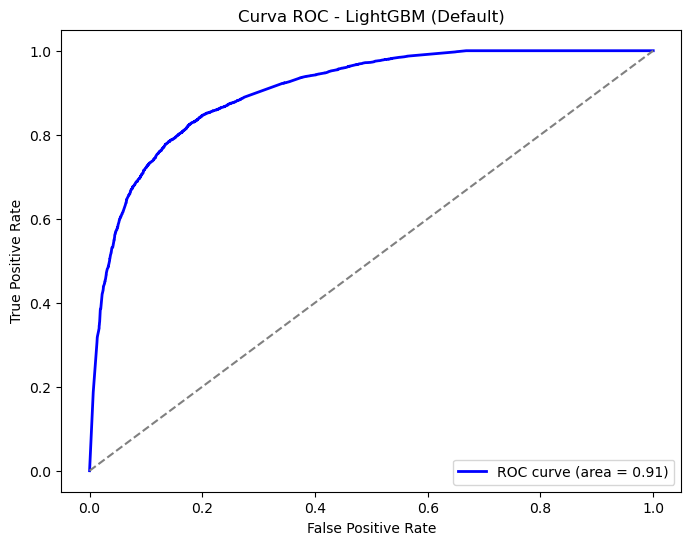

AUC-ROC: 0.9054


In [102]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
########PREPARACION DE DATOS

# Convertir columnas categóricas
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted",
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "master_metadata_album_album_name", "reason_start"
]


for col in categorical_cols:
    canciones[col] = canciones[col].astype("category")

# Convertir fechas
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True).view("int64") / 10**9


# Eliminar "spotify_track_uri" si no es relevante (parece un identificador único)
if "spotify_track_uri" in canciones.columns:
    canciones = canciones.drop(columns=["spotify_track_uri"])

canciones.columns = (
    canciones.columns
    .str.replace(r"[^\w]", "_", regex=True)  # Reemplaza cualquier carácter no alfanumérico por "_"
    .str.lower()  # Convierte los nombres a minúsculas
)

########MODELO
# Separar variables predictoras (X) y target (y)
y = canciones["target"]
X = canciones.drop(columns=["target"])  


# Primera división: 70% Train, 30% (que luego se dividirá en valid y test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Segunda división: dividir el 30% restante en 15% validación y 15% test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) #cheqiuear qwue es stratify (NO SE SABE SI ESTA BIENE ESTO!!!!!)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
val_data = lgb.Dataset(X_valid, label=y_valid)


params_lgb = {
    'num_leaves': 2**10,  # Relacionado con la profundidad, ajusta si sigue sobreajustando
    'learning_rate': 0.1, 
    'max_depth': 10,  # Equivalente a 'depth' en CatBoost
    'objective': 'binary', 
    'metric': 'auc',
    'random_state': 42,
    'verbose': -1
}

num_round = 10
modelo = lgb.train(param, train_data, num_round, valid_sets = [val_data])

# Predecir probabilidades en el conjunto de prueba
y_pred_proba = modelo.predict(X_test)

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - LightGBM (Default)")
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")


In [81]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

######## PREPARACIÓN DE DATOS ########

# Convertir columnas categóricas
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted",
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "master_metadata_album_album_name", "reason_start"
]

for col in categorical_cols:
    canciones[col] = canciones[col].astype(str)

# Convertir fechas
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True).view("int64") / 10**9


# Eliminar "spotify_track_uri" si no es relevante
if "spotify_track_uri" in canciones.columns:
    canciones = canciones.drop(columns=["spotify_track_uri"])

# Normalizar nombres de columnas
canciones.columns = (
    canciones.columns
    .str.replace(r"[^\w]", "_", regex=True)
    .str.lower()
)

######## MODELO ########
# Separar variables predictoras (X) y target (y)
y = canciones["target"]
X = canciones.drop(columns=["target"])

# Dividir en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Configurar el dataset para CatBoost
train_data = cb.Pool(X_train, label=y_train, cat_features=categorical_cols)
valid_data = cb.Pool(X_valid, label=y_valid, cat_features=categorical_cols)

modelo = cb.CatBoostClassifier(verbose=0, loss_function='Logloss', eval_metric='AUC', random_seed=42,cat_features=categorical_cols)
# Definir parámetros del modelo
grid_params = {
    'iterations': [100, 200, 300],  # Número de iteraciones
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'depth': [4, 6, 8],  # Profundidad del árbol
    'l2_leaf_reg': [1, 3, 5, 7],  # Regularización L2
}

best_params = modelo.grid_search(grid_params, X=X_train, y=y_train, cv=3, partition_random_seed=42)


bestTest = 0.8878059205
bestIteration = 97

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8878059	best: 0.8878059 (0)	total: 3.08s	remaining: 5m 29s

bestTest = 0.9003899372
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9003899	best: 0.9003899 (1)	total: 6.39s	remaining: 5m 38s

bestTest = 0.9032882384
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9032882	best: 0.9032882 (2)	total: 9.54s	remaining: 5m 33s

bestTest = 0.8881086583
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8881087	best: 0.9032882 (2)	total: 12.7s	remaining: 5m 30s

bes

TypeError: __init__() got an unexpected keyword argument 'params'

In [ ]:
#print(best_params)
# best{'params': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300},
best_params = {'params': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300}, 'cv_results': defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299], 'test-AUC-mean': [0.8853262094239304, 0.8890214633087871, 0.893074877154686, 0.8942308162366498, 0.8948925495319076, 0.8968689143830112, 0.8987713650717891, 0.8998583411874513, 0.900679856169647, 0.9012954374684198, 0.9018205262352352, 0.9022630887297686, 0.9027389782140315, 0.9031087687579668, 0.9035492938124549, 0.9039908496385486, 0.9045493493273401, 0.9049601886260122, 0.9053199690426362, 0.9056562579004472, 0.90597299620045, 0.9063187862693926, 0.906631319909439, 0.9068776163796933, 0.90715060608882, 0.9073794407507112, 0.9076155940490566, 0.907853584760329, 0.9080843279209674, 0.9082901183937179, 0.9084374375204449, 0.9085779227936867, 0.9087225332629517, 0.9088588105186842, 0.9089425990881473, 0.9090835478186414, 0.9091717076997209, 0.909242220589324, 0.9094070930014793, 0.9094838301260876, 0.9095761583029068, 0.9096381386608954, 0.9097234316433981, 0.9097958213450642, 0.9098691516403593, 0.9098986035553619, 0.909970579324496, 0.9100570648618179, 0.9101233384432815, 0.9101893526002153, 0.9102631962020066, 0.9103174045907781, 0.9103743523649496, 0.9104466368336236, 0.9104946038186955, 0.9105601031254094, 0.9106030535066005, 0.9107010467191436, 0.9107699093946184, 0.9107971691090778, 0.9108340296102907, 0.9108982320966943, 0.9109936927262501, 0.9110314479697922, 0.9110435862146448, 0.9110834842557809, 0.9111290266161767, 0.91115858185991, 0.9111761047419238, 0.9112011673377499, 0.9112505041213749, 0.9112593908708496, 0.9112771445492064, 0.9112864400834103, 0.9113267163089785, 0.91137271481958, 0.9113948621301292, 0.9114225867227993, 0.9114412426984506, 0.9114471765776392, 0.9114730207995329, 0.9115280538345992, 0.9115534820663916, 0.9115799267017254, 0.9116085748229943, 0.9116453389859588, 0.9116783443324245, 0.9116739777146563, 0.911665180592404, 0.9116943078654365, 0.9117089184434697, 0.9117133606377562, 0.9117309615279243, 0.9117425524603796, 0.9118033458072065, 0.9118282251429836, 0.911839184365399, 0.9118502915313339, 0.9118640301751949, 0.9118890206093591, 0.9119067759055568, 0.9119221920025103, 0.9119609793116723, 0.9119527402892819, 0.9120045218613031, 0.9120130558648127, 0.9120180861669187, 0.9120384631500299, 0.9120491060540696, 0.912080336085467, 0.9121104531743117, 0.9121018894459816, 0.9121459623677354, 0.91213921238969, 0.9121544604682451, 0.9121701852441452, 0.9121915895087943, 0.9122027364915075, 0.9122358114120046, 0.9122797317198694, 0.9123153003285122, 0.9123126357232452, 0.9123398498232808, 0.912364964404016, 0.91238852036926, 0.9124135205573287, 0.912423820672657, 0.9124370553798111, 0.9124575086076879, 0.9124462402521724, 0.9124820179425509, 0.9125336412633102, 0.9125570035772932, 0.912614414908203, 0.9126536277634933, 0.9126913243737763, 0.9126925005157958, 0.9127353284977877, 0.9127526523650521, 0.9127568006331689, 0.9127759762543644, 0.9127954010719354, 0.9128040143269754, 0.9128062977838244, 0.9127999760225091, 0.9128071539868747, 0.9128122215177307, 0.9128371620023694, 0.9128730517274973, 0.9128812673160634, 0.9129056338923184, 0.9129145714635122, 0.9129204540427525, 0.9129366406464238, 0.9129294203364456, 0.9129464595865433, 0.9129400922095109, 0.9129590398518065, 0.9129642844438393, 0.9129687989716992, 0.912987646323964, 0.9129924981911907, 0.913008989790141, 0.9130358219162239, 0.9130564686750832, 0.9131006165266963, 0.9131250496929004, 0.9131333901291153, 0.9131501008755948, 0.9131505997194153, 0.9131551782640196, 0.9131687353252648, 0.9131540668186315, 0.913156176799878, 0.9131784894095749, 0.9131783526653919, 0.9131913603700016, 0.9132103201989322, 0.9132155393214587, 0.9132163875785633, 0.9131965379145491, 0.9132206392973806, 0.9132361592555137, 0.9132416199369758, 0.9132472470256608, 0.9132557350853489, 0.9132624893548215, 0.9132493740718379, 0.9132601032350021, 0.9132724795252442, 0.9132914590396658, 0.91329369043331, 0.913281756317184, 0.9132830125483067, 0.913290129189909, 0.9132993116083491, 0.9132983198055031, 0.9133040466975335, 0.9133090501175314, 0.9133216307969548, 0.9133467725743728, 0.9133627420234185, 0.9133889800659566, 0.9133876035977635, 0.9134112274247856, 0.9134035507254371, 0.9133977739091508, 0.9134223091508608, 0.913434897478667, 0.9134403032229734, 0.913470684182874, 0.9134911084264045, 0.9134913409054536, 0.9134984500121863, 0.9135055734786267, 0.9135163477738071, 0.913529327131875, 0.9135263027939411, 0.9135477902670762, 0.9135577184667835, 0.9135663114784154, 0.9135869877420322, 0.9135713114673406, 0.913584181268258, 0.9136004179106939, 0.9135988597789035, 0.9135960363879357, 0.9135993449412122, 0.9136079644024866, 0.9136108046933377, 0.9136110568964781, 0.9136139401507499, 0.9136074463745848, 0.9135990662522165, 0.9135922527487882, 0.9136079200423822, 0.9136259702247896, 0.9136249440588875, 0.9136275227553202, 0.9136248627665013, 0.9136139967629514, 0.9136105607888206, 0.9136116479670898, 0.9136130188684451, 0.9135971813946222, 0.9136023488926771, 0.9135942960067741, 0.9135828813809939, 0.913594032798693, 0.9135815202565244, 0.9135881987550833, 0.9135874317905638, 0.9135987301932346, 0.9136175890423982, 0.9136075212164986, 0.9136016555351518, 0.9136062820069304, 0.9136131766429706, 0.9136214079297287, 0.9136447963530127, 0.9136515514969673, 0.9136639902326721, 0.9136618818230059, 0.9136625526424785, 0.9136520849406206, 0.9136546195048713, 0.9136560338401164, 0.9136529309247688, 0.9136487111984556, 0.9136591205627269, 0.9136563655325588, 0.9136564191883352, 0.9136676728955343, 0.9136686768997394, 0.9136673615939382, 0.9136658171281397, 0.9136800286450047, 0.9136856887642305, 0.9136762896433285, 0.9136852308672498, 0.9137067132900786, 0.9137239824070219, 0.9137166307397281, 0.9137297949737958, 0.913725166352722, 0.9137274952778496, 0.9137264178217489, 0.913720941386681, 0.9137095369486637, 0.9137048959793893, 0.913730560109166, 0.9137406399338714, 0.9137481797964154, 0.913731552799626, 0.9137302814254431, 0.9137303549288726, 0.9137420241120293, 0.9137394109092806, 0.9137443601368749, 0.9137321029059878], 'test-AUC-std': [0.002550368232615913, 0.0028144804517379733, 0.0023205535005025968, 0.0025588995583172604, 0.002759428658590408, 0.004158371332708203, 0.0033476506821079736, 0.002987492774222378, 0.0024741556223266755, 0.0022889604446249536, 0.0025761803778725292, 0.002695355271153409, 0.0025815229236703144, 0.0024390903523067624, 0.002332426548780466, 0.0026047356749592963, 0.0025793184736220593, 0.0026429753695298964, 0.002526931195375187, 0.0024180988859398554, 0.002418897854861972, 0.0024109624919168575, 0.0024650518481392687, 0.002433823646283693, 0.002465768367299788, 0.0025323460053245004, 0.002556890020618361, 0.0025866770275516275, 0.0025416197583277935, 0.0025664974943255064, 0.002563677170730499, 0.002503870816355784, 0.0024625538800626544, 0.0023763540290297515, 0.002318762617052779, 0.0023149034140200397, 0.0023339149011864795, 0.0023065903982350034, 0.0022927959922287456, 0.002281297742181716, 0.002265854994986699, 0.002241369108224221, 0.002209244114057247, 0.002188653764383161, 0.0021864156832790633, 0.0021613813890555785, 0.002150027012788009, 0.0021633990415900486, 0.002096738434119553, 0.0020874171632776165, 0.0021047769153177626, 0.0021206517573972303, 0.002142660564280479, 0.0021581321599488516, 0.0021889523687706035, 0.002183026136825601, 0.0021699637383725216, 0.0021948007934368447, 0.0021534274843453233, 0.002144344353980547, 0.0021654993240175155, 0.002204753296548782, 0.00222075939227672, 0.0021941602603726264, 0.002217714363850423, 0.002204659121123426, 0.002178470755240736, 0.002195292375350792, 0.0022114870231882016, 0.0022295816777101493, 0.0022379235730777794, 0.002251486736694554, 0.002240593763601258, 0.00225336935668543, 0.0022372984228935496, 0.002251803656930305, 0.0022751905927383895, 0.002247856134326762, 0.002239519258951532, 0.002227734931072113, 0.002224926708464146, 0.0022487454583073087, 0.002215947873487744, 0.002227487616917917, 0.002205600477020806, 0.0022055802520321334, 0.002164073621284584, 0.002170651462585786, 0.0021650825057358287, 0.0021613281905807115, 0.002148085761982641, 0.0021433302757538695, 0.0021251713593473903, 0.0021155063552557277, 0.0021194520353092178, 0.0020519060782183247, 0.002046423545187262, 0.0020349984811128797, 0.002028249927855566, 0.0020141331719386794, 0.001997876656957827, 0.0019850833257765263, 0.0019839149327891543, 0.0019913315768146133, 0.0019236859459103282, 0.0019053090268401256, 0.0019060818040965435, 0.0019081660826794668, 0.0018815492341088685, 0.0018854141313824646, 0.0019323103549663727, 0.0019410019020616068, 0.0019997532752703546, 0.0019832442835177534, 0.001960841851536776, 0.0019388331248794486, 0.0019490438668255158, 0.0019583409541196885, 0.0019709337275571736, 0.002011910413917279, 0.001985137359537764, 0.001984678046398035, 0.001982283141139296, 0.0019733500218723165, 0.0019428989980793785, 0.0019417901907224028, 0.0019371003189075737, 0.001953204818658036, 0.0019648618436390636, 0.0019666105400632347, 0.001978824296741143, 0.001984777205532362, 0.0019835057023571395, 0.002001246285471001, 0.002055585235206253, 0.002007142999345093, 0.0019936238012319744, 0.001994368284289652, 0.0019715620739596904, 0.001922697588868924, 0.0019180402508653077, 0.0019334468572326283, 0.0019513011051025043, 0.0019249797083621268, 0.0019242627969938823, 0.0019206940672769112, 0.0019262197641304294, 0.0019180769746332787, 0.0019256789828100821, 0.0019392154267140803, 0.001941088525576544, 0.0019299431181953686, 0.0019283183241124832, 0.0019349354684753525, 0.0019176342271985927, 0.0018935835817963736, 0.0019013509093415285, 0.0018748242930679891, 0.001893724925196645, 0.0019345267836448834, 0.001933964284334904, 0.0019389517606236662, 0.0019363026663396247, 0.0019166055181729313, 0.0019454419852722375, 0.0019049802593304106, 0.0018782255775445613, 0.0018355577545262284, 0.0018824814757631805, 0.0018905105455463513, 0.0019045235769158601, 0.0018749697072272006, 0.001877289455928516, 0.0018950738072988328, 0.0019011588900354646, 0.0018705065097351142, 0.0018681424957086169, 0.0018525173806709272, 0.0018517660219289852, 0.0018440267107210757, 0.0018352804453534717, 0.0018599965817138588, 0.001841162712611127, 0.0018332006219335863, 0.0018372064629106483, 0.001842677433177094, 0.0018584112105266427, 0.0018657548857186454, 0.0018662088029188216, 0.0018673220967236179, 0.0018474401302823068, 0.0018558834187671562, 0.0018637746124896756, 0.0018475155207433567, 0.0018394539915301388, 0.0018358070270358003, 0.0018250526722466843, 0.0018268474439546267, 0.001822378810502871, 0.0018155224881176157, 0.0018171480110348284, 0.001811131135255376, 0.0018100016143458304, 0.0017924176046993363, 0.0017583840102922991, 0.0017654194889972243, 0.0017832395255428647, 0.0017651203376867998, 0.0017631315866915363, 0.0017531466733967187, 0.0017800362448407577, 0.0017496781006845433, 0.0017557727433588782, 0.0017435059117977844, 0.001759097253508614, 0.0017624867105700897, 0.0017527283614411915, 0.0017541210694751745, 0.0017532624995758275, 0.0017482524990776113, 0.001730891617232848, 0.0016873914545154226, 0.001693193512583736, 0.0016957324466037942, 0.0017204539418664362, 0.0017175060316969011, 0.0017207956910023218, 0.0017267796283341036, 0.001736555154829577, 0.001722783593682454, 0.0017138764636578246, 0.0017321217003701704, 0.0017415846024645592, 0.0017331029274328647, 0.0017237927094521399, 0.0017027327146038637, 0.0016833922695570999, 0.0016849999950769802, 0.0016843225512475765, 0.0016816063126358551, 0.0016944060016995087, 0.0016975933607003711, 0.0016985222169338498, 0.0016845308869657511, 0.0016900018484529219, 0.0016900798622113925, 0.0016894993985978113, 0.0016860555138751058, 0.0016742984828214344, 0.00165761003194598, 0.001654436740555659, 0.001639938239721129, 0.0016385739682747613, 0.001634936622640766, 0.0016461446648844077, 0.0016436040144963754, 0.0016125730398147172, 0.0016109919198910173, 0.0016074079385470156, 0.0016105024929108573, 0.0016066964526425015, 0.00162162269781427, 0.00162960651606345, 0.0016176909209389234, 0.0016076786642089064, 0.0016023120080248545, 0.0015973372502574173, 0.0015973912269642652, 0.0015958401575578687, 0.0015994867960175644, 0.0015993933594131346, 0.0015957380039425134, 0.0016047943521284467, 0.0015964210831061114, 0.0015961279927904648, 0.0016134099059716327, 0.001606739004444733, 0.0016185431987038074, 0.0016482671977796422, 0.0016500440789693849, 0.0016289209968663556, 0.0016116611783620425, 0.0016131691653768771, 0.0016453225978423414, 0.0016369412564654865, 0.0016408482987061645, 0.0016531962469200424, 0.0016444209293405934, 0.0016870881757199616, 0.001683381815738588, 0.0016741694542819513, 0.0016579390477450095, 0.0016775386674059958, 0.001655808292676169, 0.0016496073882864464, 0.0016170642381292976, 0.0016015562079521035, 0.0016105359270728427, 0.0016170763191474444, 0.0016136721070761845], 'test-Logloss-mean': [0.6225457717916605, 0.5600248299713994, 0.5218938504110054, 0.49177496852410657, 0.47041174642629824, 0.45231075391701664, 0.43836142194949, 0.4278002109545523, 0.42053532311602737, 0.4144420910799301, 0.40854546162376265, 0.4044290716296322, 0.40086078615001663, 0.3981070216559044, 0.39517734336902316, 0.3927359581916749, 0.39044391135171036, 0.38849063746854257, 0.3868955892010453, 0.385584726638638, 0.3843617452269783, 0.3832083485898905, 0.3820836490696169, 0.3811976235398828, 0.38031045532610913, 0.379590396795976, 0.37890684154024384, 0.3782275994968442, 0.3775788802025377, 0.37699253138592853, 0.3765790742275172, 0.3761674587328778, 0.37581911093613557, 0.3753984772410833, 0.37509596287032837, 0.37474614721099436, 0.374506611656464, 0.3742927607806565, 0.37392116954128, 0.3737275428153423, 0.3734616560838129, 0.37328396845479817, 0.3730681334301566, 0.3728528872035972, 0.3726828556935778, 0.3726084965773162, 0.37242955633566144, 0.3722130001498703, 0.37202498881576007, 0.3718961871747326, 0.37170515558207523, 0.3715522879497619, 0.3714384271189772, 0.3712859894078924, 0.37119018576973967, 0.3710428130082715, 0.37092552001581874, 0.37072165881916685, 0.3705532758973454, 0.3704728991603414, 0.37038587489703545, 0.3702538733750564, 0.3700565745488438, 0.36998512670780936, 0.36992917849511775, 0.36981774508967497, 0.3697230691610052, 0.3696569164650272, 0.3696099294023001, 0.3695623388442499, 0.3694566333852751, 0.3694167279893091, 0.3693768329845872, 0.3693517115094724, 0.36927635671958114, 0.36916947804376044, 0.3691243419589303, 0.3690515445248292, 0.3690119356701272, 0.36898373909049703, 0.36893617363092535, 0.3688312474084947, 0.3687735988455663, 0.36870113669905463, 0.36862784643842555, 0.36855792219522715, 0.3684921050125128, 0.36849045658323054, 0.3684977431572362, 0.3684306451994485, 0.3683901868389117, 0.3683693078581669, 0.36832432209354754, 0.36830456497648295, 0.3681965065915962, 0.36814164233950325, 0.36811485617780937, 0.3680879720958794, 0.36806744156671106, 0.3680144496905469, 0.367976955546007, 0.367943889370465, 0.3678757609727634, 0.36787415522654826, 0.3677764078520663, 0.3677563597318449, 0.3677435452629136, 0.36771022161614825, 0.36769054373827686, 0.3676349393992422, 0.367581618429232, 0.3675817123002217, 0.367502120715876, 0.3675029075811557, 0.36746767630567173, 0.3674346870500609, 0.3673964334061928, 0.3673646888518845, 0.36731311801636907, 0.36721199474559346, 0.3671363830788845, 0.3671264618206238, 0.3670618375557794, 0.36701813718824344, 0.36697160306964854, 0.3669274854624332, 0.3669077093738518, 0.3668855203876848, 0.36684370978998965, 0.36685046484318273, 0.36677476678054766, 0.3666731516511433, 0.3666098063008187, 0.36651296599662225, 0.36644746763833197, 0.36636530246348054, 0.36636210456547164, 0.3662752570238646, 0.36624744165777673, 0.36624307651503085, 0.3662032513450298, 0.36616914209792584, 0.3661495888755309, 0.3661380712441844, 0.3661375817705332, 0.3661184266093965, 0.3661022349160962, 0.36604946805989647, 0.36598249952615564, 0.36596547531238444, 0.3659029259092768, 0.36587981893247185, 0.365869569081801, 0.36584686938696676, 0.36585481912984075, 0.36582014707833066, 0.36582751320696394, 0.3657804216952493, 0.36576077722162664, 0.36574951508050163, 0.3657147257179912, 0.3657076584908781, 0.36567435415839133, 0.3656270225962015, 0.3655835766573298, 0.36548699114102234, 0.36544573477489145, 0.3654261232062459, 0.36538840791562593, 0.365393116775439, 0.36537785209944323, 0.36534362085125266, 0.3653670016201029, 0.36535408471858727, 0.36531032491897025, 0.3653047410097619, 0.3652732341195201, 0.36523680114297513, 0.3652311585378314, 0.36523262069407575, 0.36527137558805317, 0.365221014694856, 0.365192147898972, 0.36517507040387026, 0.36516928536999366, 0.3651477737063497, 0.36514261123392927, 0.365165260198374, 0.36514638842479913, 0.3651296671352832, 0.36509364710731534, 0.3650838406800399, 0.3651097797102949, 0.36511594602273983, 0.36509216782419013, 0.36507402737037803, 0.3650774720373207, 0.3650558245088315, 0.36504500875462526, 0.36501460874835406, 0.3649704700740298, 0.3649440162586446, 0.3648845983857993, 0.36488256392442836, 0.36484363947831416, 0.3648495915560868, 0.3648636654271146, 0.36482061041784847, 0.364792629633472, 0.364777908847484, 0.36472216177659894, 0.36468591420859425, 0.3647061821494823, 0.36469677006331463, 0.3646800438393269, 0.36465213809109476, 0.36461887400085996, 0.36462206071866393, 0.36458064312903055, 0.36456751893894385, 0.3645566834134457, 0.3645091081027531, 0.3645373588987009, 0.3645235536348606, 0.3644900363870698, 0.36448906157259015, 0.3644925703127775, 0.36447164097324114, 0.36445485642568354, 0.36444125522699977, 0.36443340346061626, 0.36442936109334173, 0.364435599537587, 0.36444562736167035, 0.36446673069284685, 0.36444964092951854, 0.36441345781000267, 0.3644023068167999, 0.3644043360141182, 0.3644070796944612, 0.3644274832048677, 0.36442393955334546, 0.3644211776136244, 0.36441733754588973, 0.36444767921329974, 0.3644304941942866, 0.36444235508930706, 0.36446351630258517, 0.3644359136574236, 0.3644505863445131, 0.3644356754795925, 0.36443328288432464, 0.3644148559232177, 0.364381550259258, 0.3643806524190816, 0.36438770782504765, 0.3643703813523092, 0.36435155241597944, 0.364326388741365, 0.3642803217771566, 0.3642666411500728, 0.36424477632119956, 0.36424872214829, 0.3642497751495622, 0.36426845223964266, 0.36426498364948895, 0.3642635080631577, 0.36426609560087825, 0.36426538456814894, 0.3642480437632556, 0.3642546697981656, 0.364252122656322, 0.3642324779497754, 0.3642357111533203, 0.36424802206335966, 0.36424517465262146, 0.3642188663256803, 0.3642052453661235, 0.36421147051409103, 0.3641911659099935, 0.3641528807293548, 0.364113384050009, 0.3641286325821958, 0.3641043365628877, 0.36411195770360627, 0.3641148388088377, 0.36412118689097533, 0.3641376719757485, 0.3641615146708277, 0.3641680362668221, 0.36411388043333526, 0.364100309285011, 0.36408065964628955, 0.3641137631199664, 0.364103499590948, 0.36410563947203695, 0.36408446379238085, 0.3640945013004105, 0.3640868654920211, 0.3641087711044168], 'test-Logloss-std': [0.0001048165616652943, 0.0004066378299074493, 0.0017668421508299104, 0.001701611484528254, 0.0008300248003539489, 0.002133963671423614, 0.0016578856963647838, 0.002221573883720116, 0.001886482742541705, 0.0022455590120926683, 0.002571578135146151, 0.002955184745221037, 0.002796723624505641, 0.002736735756303453, 0.0028132134442610977, 0.003580613167763091, 0.0035589228500716194, 0.0037644642041173054, 0.0036273139356902823, 0.003471964715711691, 0.003539080959951772, 0.0037137356487360277, 0.0038761865075326043, 0.003941263928701338, 0.004074663313201633, 0.0041945033966933176, 0.004320155700891787, 0.004364026525919896, 0.004264083608106578, 0.004327430873026048, 0.004388169920034081, 0.0042683143548376875, 0.004213545772217757, 0.004056570849991165, 0.0038978580554664528, 0.0038706258690305263, 0.0039174757261693305, 0.0038690580361967425, 0.003871544285629604, 0.0038406601009353548, 0.0038111278926820495, 0.00379132728431114, 0.0037621536682465786, 0.0037404743250590415, 0.003758533423511777, 0.0037242960100760825, 0.003714785846619813, 0.0037454821718070318, 0.0036290589749055206, 0.0036287256866259967, 0.003669060235823372, 0.003707886067737825, 0.0037451672937504413, 0.0037839030951023513, 0.0038505900921345436, 0.0038250870156094066, 0.0037861593748195837, 0.0038426654749516603, 0.003750419996218532, 0.0037413384359337625, 0.003783740508332743, 0.0038433529351077026, 0.0038618227729574476, 0.0038208579321176513, 0.003850424308894088, 0.0038431293543731778, 0.0037914769938385677, 0.0038507497818204123, 0.0038676008126295636, 0.003907998160535663, 0.003926713915893618, 0.003960099562354343, 0.003944567094997121, 0.0039373015010536775, 0.003910431439608702, 0.00394797136583652, 0.00398570080338003, 0.003940296612635301, 0.0038992766035371184, 0.0038852512515604905, 0.0038790569063781727, 0.00392975657797784, 0.003868275969566436, 0.003897519053389175, 0.003854082706621003, 0.0038519730821762236, 0.0037886752304872933, 0.003783985848466022, 0.0037728634289976287, 0.0037703198610080065, 0.0037409558934144603, 0.0037305636661408453, 0.0036950322608948673, 0.003682790558014143, 0.0036852547579858913, 0.0035503025819280634, 0.003549667719864937, 0.00352940184484864, 0.0035132454836284232, 0.0034875038028635823, 0.003457426398931134, 0.0034378979284442886, 0.0034198894854024, 0.0034485696084698187, 0.0033365365315654676, 0.003311947262543663, 0.0033193235051159203, 0.0033240632195323423, 0.003286521961612174, 0.0033025754916354362, 0.003376469890516503, 0.0033876755516026444, 0.0034969901257721836, 0.00345064982377786, 0.0034122299803207795, 0.0033800045815425587, 0.00339974498311133, 0.0034095988175814377, 0.0034331093901419523, 0.003503134063108299, 0.0034599830505079093, 0.0034858273175169888, 0.003471468051357355, 0.003452959143704341, 0.0033908406311097977, 0.0033945745905778254, 0.003382084690406918, 0.0034179767619722436, 0.003436420978616292, 0.0034258239551699854, 0.0034418060510024774, 0.003452500949723613, 0.0034338756076984136, 0.0034631401370884556, 0.003547678112133048, 0.003462346625167137, 0.0034399205878897204, 0.0034376580405722826, 0.0034095507322916448, 0.003322551554313838, 0.0033158385091492174, 0.0033454416799835727, 0.003370653026170067, 0.003327964530735729, 0.003323698878838952, 0.0033118434258539546, 0.003329123703225648, 0.00331128895025981, 0.0033288252228590477, 0.003356753441545523, 0.0033403945110111392, 0.003320320675123483, 0.0033129917368212042, 0.0033195691332801058, 0.003287202765402887, 0.003234859764568603, 0.0032496535901214985, 0.0032150008514870414, 0.0032528464001556944, 0.0033125793613539584, 0.003305250474640953, 0.003317309781123544, 0.003305572416615113, 0.003269653962280953, 0.00332831267596329, 0.003253489314164466, 0.0032075693880635253, 0.003126643148045612, 0.003205049948449777, 0.0032215454662127864, 0.0032440312995679317, 0.0031971020345131465, 0.0032021734407738918, 0.003235684254953726, 0.003240307643979208, 0.0031842310061642384, 0.003199233362617124, 0.00317636515920975, 0.0031798591252639634, 0.0031741093750253697, 0.0031522392561051642, 0.0031980116643440613, 0.0031564312878475448, 0.003136870838384374, 0.0031447195445437706, 0.0031460760066381733, 0.0031758426979352325, 0.0031958287988440416, 0.0031959028457446046, 0.003203672337764003, 0.0031684249106125836, 0.0031809809644374023, 0.003192431781546389, 0.0031611697397304333, 0.003155800976284767, 0.003147624735227803, 0.0031353456663634517, 0.003148683612773749, 0.0031388720120119357, 0.0031225736193738664, 0.0031311781773182405, 0.003120735106294778, 0.003123333414531328, 0.003087925888435457, 0.00303094721028541, 0.00303200704724287, 0.003061460351445359, 0.0030288749038855567, 0.0030291683696267242, 0.003007215560289884, 0.0030544645112859817, 0.002999842795650667, 0.0030270122324753857, 0.0030229301007073765, 0.003047461428419122, 0.00305383925989715, 0.0030349039466124224, 0.0030498197228652304, 0.0030725971868729583, 0.003053098815706394, 0.0030162661916495314, 0.00292560066013976, 0.002937071410354237, 0.0029483619535667833, 0.002996990297955373, 0.002984384689359099, 0.0030019110856225498, 0.0030140051278617027, 0.003034769583038084, 0.0030116659521987436, 0.0029967681895107655, 0.003025620683566873, 0.0030534403450005573, 0.0030382352066568104, 0.0030174347896409735, 0.0029861245887682956, 0.0029661862254379626, 0.002962609335448476, 0.002948023041180306, 0.0029360802497034005, 0.0029622456930223614, 0.002961960999002463, 0.002963492841382827, 0.0029334738014473692, 0.002942574280295562, 0.002939224855131285, 0.0029375793476179163, 0.002936893573394279, 0.0029081489450023664, 0.0028772008277041334, 0.0028790521519182987, 0.0028522783278922092, 0.002842742599806575, 0.002841742436304276, 0.002831784271257563, 0.0028250815502172465, 0.0027674720893148914, 0.0027593807578576894, 0.0027562576356611407, 0.0027577456432991087, 0.002751435826609922, 0.002767425660412554, 0.0027737062042029656, 0.0027555117898007075, 0.002730119043618222, 0.0027192302098345417, 0.0027126851907352313, 0.00271009433734332, 0.0027053604428324907, 0.002711517903769939, 0.002711436123338314, 0.0026987848615652745, 0.002714652697827546, 0.002696005460539654, 0.0026978285232960877, 0.002726674502852741, 0.002714411964734578, 0.002737499906181025, 0.0027982668757274994, 0.0028022444224216686, 0.002756879809550545, 0.002717613594625372, 0.0027284614561679872, 0.0027872909146579522, 0.002775805883912605, 0.002790761996686611, 0.0028159705344082595, 0.0028111561814217756, 0.002886569631594723, 0.0028829849148253083, 0.0028603588985114665, 0.0028325600919610954, 0.0028667917182518595, 0.0028188726875544813, 0.0028089912413976938, 0.002756818982157848, 0.0027300895311284145, 0.0027463122607950413, 0.002760786172509297, 0.002756736368389142], 'train-Logloss-mean': [0.6228145751982911, 0.5604358548858228, 0.52224907567521, 0.4925763849154324, 0.47133132875580713, 0.4533502749088716, 0.43946584405403777, 0.4290006835154932, 0.42153768519546997, 0.41536328471711687, 0.40935720483197074, 0.4052107952743487, 0.401664303629901, 0.3987605434626566, 0.39577594622363704, 0.393230125755938, 0.391002000419484, 0.38902415347149794, 0.38738322363196437, 0.38609383807333447, 0.38484322812281047, 0.38367092247253937, 0.3825662024463634, 0.3816314680752422, 0.38074284013921544, 0.3798676011561028, 0.3790325491924205, 0.37830431926837177, 0.3776334962978683, 0.37689367363212267, 0.3762600122749444, 0.37565698569037614, 0.37526335449251946, 0.3746134323594778, 0.37411125059982653, 0.3734643406513358, 0.3730227219799154, 0.3726128743098798, 0.3721581537005068, 0.3717396061593836, 0.3711757206899446, 0.37086715434335976, 0.3704572471840761, 0.370085062173608, 0.36969565395809806, 0.36946257978020314, 0.36914065569803123, 0.3686769856935089, 0.3682025512257236, 0.3677883170395881, 0.36745206990463225, 0.366957324065671, 0.3666642366983683, 0.36633834168770907, 0.3660924147974753, 0.3657026036931675, 0.36540475983742177, 0.36502987394793934, 0.3645549070455454, 0.36427386288146657, 0.36397494757391086, 0.3636534335834248, 0.3633548174361443, 0.3630756984235766, 0.36282288200772417, 0.3624399668291265, 0.3622120209035626, 0.36193189134482234, 0.36163329147604234, 0.3614302655247091, 0.36115408004929533, 0.36083959556401934, 0.36057842146243685, 0.3603044661904851, 0.36004865600966185, 0.35971092120925235, 0.3595616402263233, 0.35912654441697295, 0.3589083600667831, 0.35867630021133695, 0.35849724606274896, 0.35818258396566466, 0.3579170086181733, 0.3577369888197752, 0.357459578110421, 0.35719536150634595, 0.3569053815840681, 0.35667995040033434, 0.3564327856493968, 0.3562261810861281, 0.3560915922494876, 0.35594064726494756, 0.3557362767977463, 0.3555228463316955, 0.35524770380947474, 0.35502703056574153, 0.3548545298905212, 0.3546153463617305, 0.3544680320959035, 0.3541950457345651, 0.3539220781964358, 0.3537582686479377, 0.35349004798323963, 0.3532343108866603, 0.35292914923797564, 0.3526725738270758, 0.35238471966098633, 0.3521829269668035, 0.3519049648813665, 0.35158648653658414, 0.3513763319756757, 0.3512049109470199, 0.35093283379374046, 0.35073736495072866, 0.35044007380989256, 0.35012851915837356, 0.3498971563485796, 0.3497237452552222, 0.349517416860893, 0.3492492557123384, 0.34897143438229333, 0.3487629454554603, 0.3485449487696619, 0.34834981611490906, 0.3480665370272571, 0.34780894516986754, 0.3475926073036892, 0.3473240281650511, 0.3470830152435191, 0.3468232906361746, 0.34659843272437446, 0.34636855994074917, 0.3461525043916142, 0.34593482579057017, 0.34569108380470775, 0.3454153723963879, 0.3450871114430285, 0.34479857212457166, 0.3445812884099584, 0.3442815770309052, 0.3441363636558597, 0.3439389688706192, 0.34370588599570473, 0.3434992045902865, 0.34324189855702764, 0.3429819010262549, 0.34275100411804793, 0.3425468553524014, 0.34237063809395024, 0.34220105163854636, 0.3419896164089739, 0.3417943383372459, 0.3416556405461993, 0.3414444933311272, 0.3412005296547595, 0.34099703074080095, 0.3408874817560654, 0.3406516004849444, 0.3404346352485659, 0.34022813410808844, 0.3400512521209347, 0.33981544987120244, 0.33970787991374735, 0.339519312911831, 0.33931446918109437, 0.3390978708168959, 0.33890997921489446, 0.33872559164332894, 0.3384177519794708, 0.33821537741369334, 0.33801163378659904, 0.33776933228039385, 0.3375685181526129, 0.33734990335632925, 0.33721099025451906, 0.3369386110788959, 0.3367058225156432, 0.3364236292275648, 0.33627102729312836, 0.3360914592987638, 0.3358732448810981, 0.33570360151088363, 0.3355214779776891, 0.33534792910651584, 0.33520033089220463, 0.33504540184131776, 0.33488264137016727, 0.3347165083889025, 0.3345660731495344, 0.3344244308099724, 0.3342825379407944, 0.334176250957486, 0.3339550052059989, 0.33370787108349065, 0.3335160731438119, 0.33332286353852186, 0.3331934394460827, 0.33305164284739036, 0.33295835321430534, 0.3327293241582658, 0.3325663881684651, 0.3323955495720536, 0.33213002814565734, 0.33194581941520035, 0.3318188165856588, 0.3316465366948403, 0.3314995031889843, 0.33130993525447844, 0.33114391564858503, 0.3309859470816298, 0.3307802337088202, 0.3306332403310433, 0.33039251984807444, 0.33025574439655325, 0.3301237581927379, 0.3299423640345034, 0.3297089538392927, 0.3294867559757965, 0.329257082441073, 0.3291130150123867, 0.3289709590208972, 0.32877708350518464, 0.3286271885752547, 0.3284506938536085, 0.32824348023926625, 0.3280634448192556, 0.3279090713429475, 0.3276640240116348, 0.3275558855491249, 0.32737706031224856, 0.32712672526288666, 0.32696036403674783, 0.32680145680008543, 0.32658271135241446, 0.32646359344034376, 0.32621430098246434, 0.326044576792746, 0.32588544765601263, 0.3257477997430939, 0.3256245713516593, 0.3255003078530784, 0.32534831083459537, 0.32522065218550283, 0.32507741540483664, 0.32491560670286807, 0.32471256515520397, 0.32448860730797896, 0.3244124192615852, 0.3242898274198934, 0.3241148825433261, 0.32393435273847976, 0.32374089107577725, 0.3235817892892567, 0.3234214323488869, 0.3231822025164531, 0.3230166016006144, 0.32279782237940385, 0.3226450306249618, 0.32249262648387683, 0.3223433041773361, 0.3222107014339022, 0.32200877117664123, 0.32182893049434713, 0.3215979174010439, 0.32144834223295254, 0.3212410442299831, 0.3211347017333397, 0.32104349758299, 0.32095623921652244, 0.3208386442890588, 0.3207165411546666, 0.32063666066473034, 0.3204949544815312, 0.32030635555412257, 0.3201500229089758, 0.32003641874380073, 0.3199111397724326, 0.3197983431567788, 0.31961341477849076, 0.319441590097941, 0.3192448026383938, 0.3190929592445248, 0.3189047720501023, 0.3187379975945398, 0.3185095874539275, 0.3183398640545054, 0.31816828420120497, 0.3179722442430694, 0.317827348321927, 0.31779683297648204, 0.31764026556433655, 0.3174639788770895, 0.31734540378102594, 0.3172146260456823, 0.3170544283834195, 0.3168254542771369, 0.3166811651706496, 0.31648979771404123, 0.3162944905805231, 0.3161701162432398], 'train-Logloss-std': [0.00035805420929711253, 0.0008907942812930165, 0.0032647550590567415, 0.0032764419923364675, 0.0030796857099437444, 0.0034243886543054536, 0.002817904769180078, 0.0012546953075572842, 0.0021844376452667055, 0.0024292870124049135, 0.0017799722680100938, 0.001211258044594798, 0.0013310361806758426, 0.001513664702276687, 0.001534438311939207, 0.0010388597927642913, 0.0010990644924173554, 0.0010713116564108702, 0.001180771287119091, 0.0012605447235188576, 0.0013701681274241775, 0.0012402097642289505, 0.0009918253361811398, 0.0009711237213503656, 0.0008728305580492208, 0.000903944856141013, 0.000968936645446642, 0.0009359156860992092, 0.0009872877629129105, 0.0009055638387999371, 0.0008341649075672487, 0.0009664026066660501, 0.0010316434907148594, 0.0011422720813356918, 0.0013502662258264761, 0.0013010821383200647, 0.0013285480340852493, 0.0013796976072848945, 0.0014054580371791363, 0.001553519575863349, 0.0015437912266408154, 0.001569066026146812, 0.0014765377168430873, 0.0015545392520094074, 0.0016602815441565846, 0.001669482285210625, 0.0017180009367414864, 0.0016028249330558811, 0.0017447334347139795, 0.001817918861785414, 0.001800520677595819, 0.0017639122804364935, 0.0017025873715532565, 0.0016199978046244174, 0.0016181648074285303, 0.0016539462837274616, 0.00164155179309281, 0.0017043146202881823, 0.0016586087891971451, 0.0017237770822439156, 0.0017215201413350737, 0.001731135934957553, 0.0017085191317902624, 0.001759973019144869, 0.0016719078093665684, 0.0016982421181826626, 0.001688681862319749, 0.0016169684771273347, 0.0017058462105996796, 0.0016126180174208223, 0.0015902390917828968, 0.0014542002391159032, 0.0013650263430970515, 0.0015598187823353963, 0.001471962107392741, 0.0013721481861800784, 0.001382442661319621, 0.001250248568878666, 0.0011556632359611013, 0.0011862365293663264, 0.001186706833239148, 0.0011140397249475953, 0.001244395553695201, 0.0012472181910194806, 0.0012337092416498268, 0.001238422985122553, 0.001111123794685314, 0.0011426628263781864, 0.0011705964326659145, 0.0012616719415928764, 0.0012808770774868188, 0.0012543846282198005, 0.0012484762827945353, 0.0012415717049223205, 0.0011870559416728742, 0.0012434583455246152, 0.001291893488151831, 0.0012637335637713297, 0.0012816796671655678, 0.0014743859317588289, 0.0015579502294385036, 0.0016338237635012641, 0.0015358333259232288, 0.0015315573584788902, 0.001570155841965806, 0.001588573935938078, 0.0015249689343824937, 0.0016069294340541821, 0.0015880856182798658, 0.0015436800319973151, 0.0015203240714293704, 0.0015501141272227996, 0.0014723705211927352, 0.0015512764739709463, 0.0015956956581121234, 0.0017660544252770716, 0.0016556782000360496, 0.0016172145343991942, 0.0015608475264512318, 0.0014862905559088623, 0.0015082043333211048, 0.0014306533969533682, 0.0013752076680900208, 0.0014121764039214833, 0.0015625029784847755, 0.0015225439355489655, 0.0015978540810088506, 0.001517045301696346, 0.0015594888860280406, 0.0016182719273690614, 0.0016085098867417145, 0.0015460835206776474, 0.001497141887830341, 0.0015325465773005982, 0.0014814220563456127, 0.0014967584229228297, 0.0015640268014889536, 0.0015549552112160308, 0.0016022339719772636, 0.0016802436484389795, 0.001622191666666553, 0.001601321082018925, 0.0015101136353318483, 0.0015529259400837332, 0.0015442724927335627, 0.0015507773923568227, 0.0015848237024981675, 0.001562293026352224, 0.0015557929120202177, 0.0014904186392328104, 0.001426286144618065, 0.0014421558341632084, 0.0014423878216895177, 0.0014313762647977664, 0.0014033418206332324, 0.0013831436445802647, 0.0013851189090300022, 0.0013966260655048316, 0.0014230386849966915, 0.0014000166483858012, 0.001389536114426291, 0.0013590033401314435, 0.0013219468830785272, 0.0014774666929494658, 0.0014461370903062717, 0.0015211413344493035, 0.0016157676074482251, 0.00158770756855241, 0.001585118989285098, 0.0016171837544412323, 0.0016110265342358782, 0.0016694659998115113, 0.0016277800735297544, 0.0016590895155768942, 0.001602304907562724, 0.0015475175852206811, 0.0014635070499492498, 0.0014652143760507275, 0.001456838674925953, 0.0014538908316698788, 0.0014783335090542853, 0.0015118115147542519, 0.0015248346320652746, 0.0014784144152875478, 0.001441011851709618, 0.0014882168653885185, 0.001543886820744295, 0.0014955442725280274, 0.001565574637785868, 0.0016289820788149803, 0.0016743280984760276, 0.0016688598456368775, 0.0016683319144816734, 0.0016094630632579204, 0.0016022683785700484, 0.0015793507191632329, 0.001564125958742008, 0.0016245800791936807, 0.0016068881204895206, 0.0014919469640072606, 0.0015204802902670676, 0.001572938138228281, 0.0014709041412430347, 0.0014812188539004678, 0.0015370746905683313, 0.0015518053006646861, 0.0016263299909066158, 0.001609735045795691, 0.0015673439093613455, 0.001601015517387423, 0.001629941785078205, 0.0016861946497850925, 0.0017699239883050676, 0.0017954505731940015, 0.0017563495196090862, 0.001649527154918007, 0.0016770211395847905, 0.0016446233701120634, 0.0016346371479540867, 0.0016938518241810213, 0.0017365901905072652, 0.0017979540901493548, 0.0018522210828186636, 0.0018741325373157459, 0.001877711456841174, 0.0018922783381685512, 0.00197962234037135, 0.0021428952690088084, 0.0021689032118339894, 0.002190526571877327, 0.002108136595702181, 0.0021116640531036344, 0.002042192569304144, 0.001977021311583422, 0.0020082041849077263, 0.002022927648285419, 0.0019916587113339686, 0.0019301043682866529, 0.001954398583915827, 0.002022799616543759, 0.0020487336813300814, 0.0021029514629563187, 0.0020611708704135387, 0.0020658464172545973, 0.0020770475128433067, 0.0020276471838243087, 0.0019499778442345803, 0.0019061519435760906, 0.0019185565459461835, 0.0018791626505269016, 0.0018616272613251157, 0.0017765311514045077, 0.0017146308244277548, 0.0017474090442384624, 0.0016782736652937308, 0.0016438021835277258, 0.0015861304600468475, 0.0015056636107972552, 0.001414819208774846, 0.0014432165289424322, 0.0014528571001263199, 0.0014076209498871276, 0.0013443617876439757, 0.0014071643947648083, 0.0013293498926965134, 0.001263733018238634, 0.0013496232298156928, 0.0013280486531417237, 0.0013377542097803645, 0.0012893459073397998, 0.0012841484275326726, 0.0012691723915641798, 0.0012651582280517925, 0.001277767091135224, 0.0013113420281627972, 0.0013498784690358302, 0.001328499327920065, 0.0013081493859405523, 0.0013377138202577796, 0.0013331719648423865, 0.0013400742401061309, 0.0013772544488174104, 0.0012860186099454623, 0.0012897814704447602, 0.0013173356847520385, 0.0013023808855495513, 0.0012758489727799573, 0.0012507817010279578, 0.001306504049146406, 0.0012826311783809645, 0.0013239268108748003, 0.0013236271075434834, 0.001366644156798173, 0.0013049661918301553, 0.0012844456599632188, 0.0013361587626109462, 0.0013430085998855559, 0.0013200096128497666, 0.0013428814867024283, 0.0013003209910121493]})}

solo_parametros = best_params["params"]
# Entrenar el modelo

modelofinal = cb.CatBoostClassifier(**solo_parametros, cat_features=categorical_cols, verbose=100)

# Entrenar con todo el dataset de entrenamiento
modelofinal.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Probar distintos hiperparametros


# Predecir probabilidades en el conjunto de prueba
y_pred_proba = modelofinal.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")



NameError: name 'cb' is not defined

In [2]:
df_predicciones = pd.DataFrame({
    'ID': canciones.iloc[X_test.index, 0],
    'TARGET': modelofinal.predict_proba(X_test)[:, 1]
})

# Guardar en un archivo CSV
df_predicciones.to_csv("predicciones_catboost.csv", index=False)

print("Predicciones guardadas en 'predicciones_catboost.csv'")


NameError: name 'pd' is not defined

In [1]:
print(df_predicciones.shape[0])

NameError: name 'df_predicciones' is not defined